In [2]:
import models
import audio_utils
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import librosa
import torch.nn as nn
import os
import random
import pandas as pd
import numpy as np

In [3]:
model = models.BL_Decoder_Classifier()
model.load_state_dict(torch.load('models/AE_classifier_model_01.pt'))

<All keys matched successfully>

In [4]:
encoder = models.logMelAE()
encoder.load_state_dict(torch.load('models/logMelAE_model_02.pt'))

<All keys matched successfully>

In [5]:
rand_fn = '../speechRemoval/fin_dataframe.csv'
df = pd.read_csv(rand_fn)

f1 = random.choice(df['file1'])
f2 = random.choice(df['file2'])
snr = [5]

noise = audio_utils.add_two_noise([f1,f2], snr)
feats_ = audio_utils.get_random_audioFeatures(noise)

f1, f2

('../audioData/NIGENS/NIGENS/crash/crash-closet+of+junk_CAP01-119.wav',
 '../audioData/NIGENS/NIGENS/baby/HumanBaby+6105_96.wav')

In [6]:
with torch.no_grad():
    repres = encoder.encoder(feats_)
    out = model(repres)
    out = torch.round(out)
print(out)

tensor([[0., 1., 1., 0., 0., 0., 0., 0., 0., 0.]])


In [7]:
labels_list = df['label1'].unique()
labels_list.sort()

lab_key = [i for i in range(0, len(labels_list))]
lab_dict = {labels_list[i]:lab_key[i] for i in range(0, len(labels_list))}
#lab_dict['silence'] = 10

In [8]:
class sedDataset(Dataset):

    def __init__(self, dataframe):
        self.dataset_df = dataframe

    def __len__(self):
        return len(self.dataset_df)
    
    def __getitem__(self, index):

        fil_list = [self.dataset_df.iloc[index, 0], self.dataset_df.iloc[index, 1]]
        lab1 = lab_dict[self.dataset_df.iloc[index, 2]]
        lab2 = lab_dict[self.dataset_df.iloc[index, 3]]
        
        noise = audio_utils.add_two_noise(fil_list, [5])
        feats = audio_utils.get_random_audioFeatures(noise)
        
        if torch.isnan(noise).any():
            noise = torch.zeros(noise.shape)
            lab1 = lab_dict['silence']
            lab2 = lab_dict['silence']
            feats = torch.zeros(feats.shape)
            
               
        labels = [0 for i in range(0,10)]
        labels[lab1] = 1
        labels[lab2] = 1
        labels = torch.Tensor(labels)
        
        return feats, labels

In [9]:
split = (int)(len(df)*0.8)

train_dataset = sedDataset(df[0:split])
test_dataset = sedDataset(df[split:])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [33]:
torch.manual_seed(13)
torch.cuda.manual_seed(13)

class AEDClassifier(nn.Module):

    def __init__(self):
        super(AEDClassifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 4, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(4, 1, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(858, 200),
            nn.ReLU(),
            nn.Linear(200, 10)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.classifier(x)
        y = self.sigmoid(x)

        return y

In [35]:
sas = torch.rand([16,10,63])

AEDClassifier()(sas)

tensor([[0.4944, 0.5163, 0.5192, 0.4965, 0.5053, 0.5186, 0.5038, 0.4886, 0.4912,
         0.5091]], grad_fn=<SigmoidBackward0>)

In [36]:
sed_classifier = AEDClassifier()
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

#loss_fn = nn.CrossEntropyLoss().to(device)
loss_fn = nn.BCELoss().to(device)
optimizer = optim.Adam(sed_classifier.parameters(), lr=0.001)

In [58]:
import statistics

sed_classifier = sed_classifier.to(device)
encoder = encoder.to(device)

epochs = 10

for epoch in range(0, epochs):
    loc_list = []
    
    for data in train_loader:
        sed_classifier.train()
        optimizer.zero_grad()
        inputs, labes = data

        inputs = inputs.to(device)
        encoder.eval()
        with torch.no_grad():
            preds = encoder.encoder(inputs)
        input = preds
        if not torch.isnan(input).any():
            labes = labes.to(device)

            output = sed_classifier(input)
            #print(output.shape, labes.shape)
            loss = loss_fn(output, labes)

            if not torch.isnan(loss).any():
                loss.backward()
                optimizer.step()
                loc_list.append(loss.item())    

    print(f"Epoch [{epoch+1}/{epochs}] Loss: [{statistics.mean(loc_list)}]")

Epoch [1/10] Loss: [0.048457689634524286]
Epoch [2/10] Loss: [0.03761158710718155]
Epoch [3/10] Loss: [0.04684683478064835]
Epoch [4/10] Loss: [0.04304430365841836]
Epoch [5/10] Loss: [0.021046800826792604]
Epoch [6/10] Loss: [0.01363550879014656]
Epoch [7/10] Loss: [0.034364579882822]
Epoch [8/10] Loss: [0.028809376071440056]
Epoch [9/10] Loss: [0.028453950960887597]
Epoch [10/10] Loss: [0.02873898422671482]


In [11]:
## Evaluation
import sklearn.metrics

y_true = []
y_preds = []

for data in test_loader:

    input, label = data
    y_true.append(label.numpy())

    with torch.no_grad():
        repr = encoder.encoder(input)
        out = model(repr)
        y_preds.append(torch.round(out).numpy())

#print(sklearn.metrics.accuracy_score(y_true, y_preds))

In [12]:
yy = np.concatenate(y_true)
yp = np.concatenate(y_preds)

conf_mat = sklearn.metrics.multilabel_confusion_matrix(yy, yp)
for i, confusion_matrix in enumerate(conf_mat):
    print(f'Confusion Matrix for Label {i}:')
    print(confusion_matrix)
    print('\n')



Confusion Matrix for Label 0:
[[383  10]
 [ 17  90]]


Confusion Matrix for Label 1:
[[383  18]
 [ 15  84]]


Confusion Matrix for Label 2:
[[391  18]
 [ 23  68]]


Confusion Matrix for Label 3:
[[386  18]
 [ 37  59]]


Confusion Matrix for Label 4:
[[373  16]
 [ 15  96]]


Confusion Matrix for Label 5:
[[384  12]
 [ 29  75]]


Confusion Matrix for Label 6:
[[386  21]
 [ 25  68]]


Confusion Matrix for Label 7:
[[385   9]
 [ 22  84]]


Confusion Matrix for Label 8:
[[375  32]
 [  7  86]]


Confusion Matrix for Label 9:
[[397   3]
 [ 31  69]]




In [10]:
labels_list

array(['alarm', 'baby', 'crash', 'dog', 'engine', 'fire', 'footsteps',
       'knock', 'phone', 'piano'], dtype=object)

In [14]:
print(sklearn.metrics.classification_report(yy, yp))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       107
           1       0.82      0.85      0.84        99
           2       0.79      0.75      0.77        91
           3       0.77      0.61      0.68        96
           4       0.86      0.86      0.86       111
           5       0.86      0.72      0.79       104
           6       0.76      0.73      0.75        93
           7       0.90      0.79      0.84       106
           8       0.73      0.92      0.82        93
           9       0.96      0.69      0.80       100

   micro avg       0.83      0.78      0.80      1000
   macro avg       0.84      0.78      0.80      1000
weighted avg       0.84      0.78      0.80      1000
 samples avg       0.87      0.78      0.80      1000



/work/dpandya/miniconda3/envs/noiseremoval/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
f1 = random.choice(df['file1'])
f2 = random.choice(df['file2'])
print(f1,f2)
noise = audio_utils.add_two_noise([f1,f2], [5])
featss = audio_utils.get_random_audioFeatures(noise)

encoder = encoder.cpu()
encoder.eval()
with torch.no_grad():
    repres = encoder.encoder(featss)

sed_classifier = sed_classifier.cpu()
sed_classifier.eval()
with torch.no_grad():
    out = sed_classifier(repres)

print((torch.round(out)), lab_dict)

../audioData/NIGENS/NIGENS/knock/DOOR-KNOCK_GEN-HDF-09719.wav ../audioData/NIGENS/NIGENS/engine/AutoPorscheTurboS+5039_41.wav
tensor([[0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]]) {'alarm': 0, 'baby': 1, 'crash': 2, 'dog': 3, 'engine': 4, 'fire': 5, 'footsteps': 6, 'knock': 7, 'phone': 8, 'piano': 9}


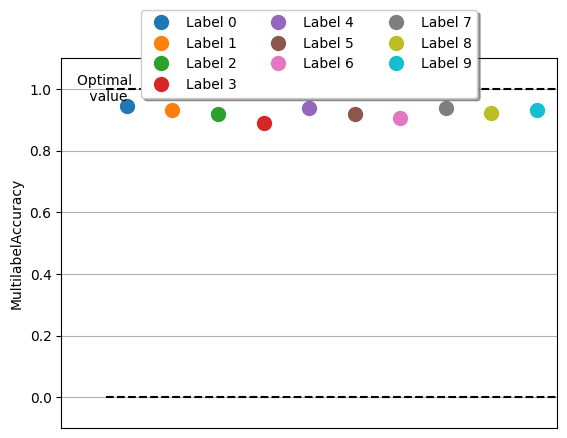

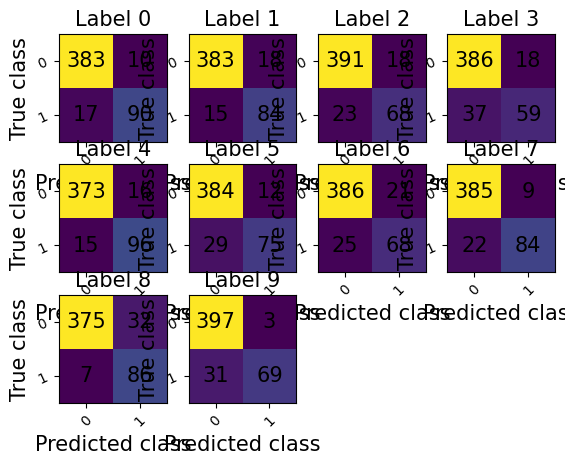

In [68]:
import torchmetrics
acc_list = []
sed_classifier = sed_classifier.to('cpu')
encoder = encoder.to('cpu')

multi_lab_acc = torchmetrics.classification.MultilabelAccuracy(num_labels=len(lab_dict), average=None)
conf_mat = torchmetrics.classification.MultilabelConfusionMatrix(num_labels=len(lab_dict))
for data in test_loader:

    sed_classifier.eval()
    encoder.eval()
    inpu, labs = data

    with torch.no_grad():
        repr = encoder.encoder(inpu)
        out_ = sed_classifier(repr)
        out_ = torch.round(out_)
    out_ = out_.to('cpu', torch.int)
    labs = labs.to('cpu', torch.int)
    multi_lab_acc.update(out_, labs)
    conf_mat.update(out_, labs)

fig1, ax1 = multi_lab_acc.plot()
fig2, ax2 = conf_mat.plot()

In [69]:
# AE_classifier_model_00.pt: 10 epochs, conf00
# AE_classifier_model_01.pt: 20 epochs, conf00
torch.save(sed_classifier.state_dict(), 'models/AE_classifier_model_01.pt')